<a href="https://colab.research.google.com/github/morenaherrera2/AA2-HerreraM-NardiG-ZorzoloJ/blob/main/Problema_3_TP1_AA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico 1 AAII 2025 - Redes Densas y Convolucionales

**PROBLEMA 3 -GRUPO N° 5**

Autores:
- Herrera Morena (H-1187/8)
- Nardi Gianella Belén (N-1277/7)
- Zorzolo Rubio Juana (Z-1217/3)

# Problema 3



Descripción: En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.

## Instalaciones e importaciones

In [90]:
!pip install -q gdown

In [91]:
import gdown
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path

from tensorflow.keras.layers import Input, RandomFlip, RandomContrast, RandomTranslation, Flatten, Dropout
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPooling2D, Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Add, ReLU, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from PIL import Image
from collections import Counter, defaultdict
import os
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image
import tempfile

In [92]:
# Fijar semilla
import random
semilla = 42
np.random.seed(semilla)
tf.random.set_seed(semilla)
random.seed(semilla)

In [93]:
# TP1-3-natural-scenes.zip
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=094693ad-f17f-45d0-b4a2-eef882d01e6b
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:06<00:00, 58.3MB/s]


'TP1-3-natural-scenes.zip'

In [94]:
with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref:
  zip_ref.extractall('./TP1-3')

## Análisis y preprocesamiento de datos (EDA)

In [95]:
# Directorio de los datos
data_train = Path('/content/TP1-3/seg_train/seg_train')
data_test = Path('/content/TP1-3/seg_test/seg_test')

BATCH_SIZE = 32 # Tamaño del lote

# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Cargamos los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_train,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_test,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [96]:
# Inspeccionamos las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Total de imágenes analizadas (hasta 440 batches): 14034
Tamaños encontrados: {(150, 150, 3)}
Conteo por clase:
  - buildings: 2191 imágenes
  - forest: 2271 imágenes
  - glacier: 2404 imágenes
  - mountain: 2512 imágenes
  - sea: 2274 imágenes
  - street: 2382 imágenes


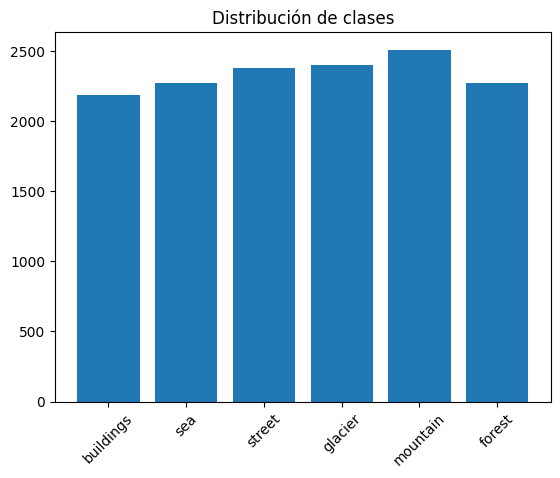

In [97]:
# Vemos distribución de las clases en TRAIN
def analizar_dataset_tf(train_ds, class_names=None, max_batches=440):
    conteo_clases = Counter()
    tamaños = set()
    total_imgs = 0

    for batch, (images, labels) in enumerate(train_ds.take(max_batches)):
        batch_size = images.shape[0]
        total_imgs += batch_size
        tamaños.update([tuple(images.shape[1:4])])

        for label in labels.numpy():
            idx = np.argmax(label)
            conteo_clases[idx] += 1

    print(f"Total de imágenes analizadas (hasta {max_batches} batches): {total_imgs}")
    print("Tamaños encontrados:", tamaños)

    print("Conteo por clase:")
    for idx, count in sorted(conteo_clases.items()):
        nombre = class_names[idx] if class_names else f"Clase {idx}"
        print(f"  - {nombre}: {count} imágenes")

    # Plot de clases
    if class_names:
        etiquetas = [class_names[idx] for idx in conteo_clases.keys()]
    else:
        etiquetas = list(conteo_clases.keys())

    plt.bar(etiquetas, conteo_clases.values())
    plt.xticks(rotation=45)
    plt.title("Distribución de clases")
    plt.show()


class_names = train_ds.class_names if hasattr(train_ds, 'class_names') else ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

analizar_dataset_tf(train_ds, class_names, max_batches=440)

Total de imágenes analizadas (hasta 440 batches): 3000
Tamaños encontrados: {(150, 150, 3)}
Conteo por clase:
  - buildings: 437 imágenes
  - forest: 474 imágenes
  - glacier: 553 imágenes
  - mountain: 525 imágenes
  - sea: 510 imágenes
  - street: 501 imágenes


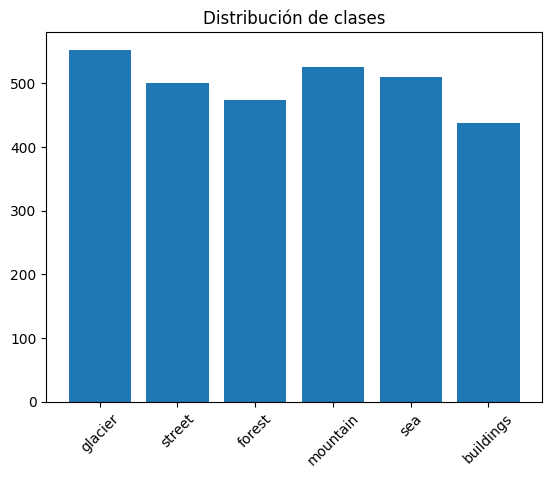

In [98]:
# Vemos distribución de las clases en TEST
analizar_dataset_tf(test_ds, class_names, max_batches=440)

Conclusión: Si bien las clases no tienen exactamente la misma cantidad de imágenes, la diferencia entre la que más tiene y la que menos tiene es relativamente baja (alrededor del 10-25%), por lo que concluimos que el conjunto de datos está relativamente balanceado.


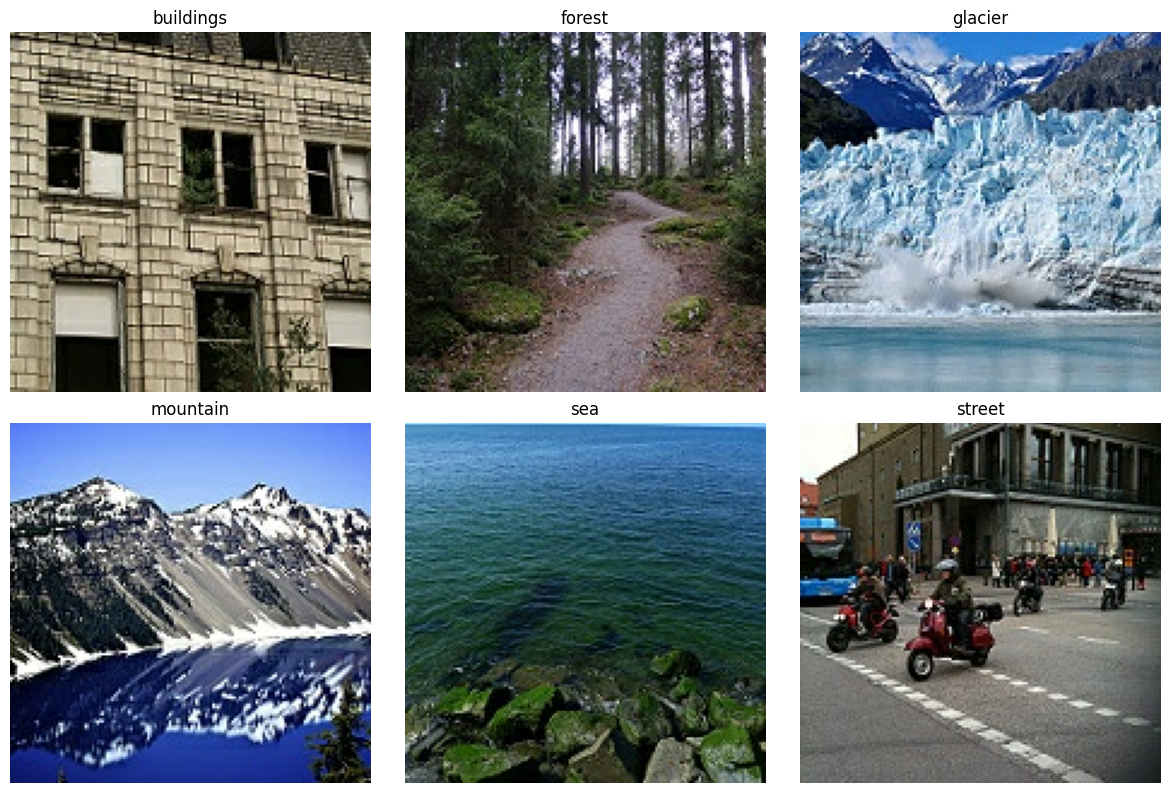

In [99]:
# Mostramos imágenes por clase

def mostrar_ejemplos_por_clase(dataset, class_names):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    mostradas = [False] * len(class_names)

    for images, labels in dataset.unbatch().take(1000):
        idx = np.argmax(labels.numpy())
        if not mostradas[idx]:
            ax = axes[idx // 3, idx % 3]
            ax.imshow(images.numpy().astype("uint8"))
            ax.set_title(class_names[idx])
            ax.axis("off")
            mostradas[idx] = True
        if all(mostradas):
            break

    plt.tight_layout()
    plt.show()

mostrar_ejemplos_por_clase(train_ds, class_names)

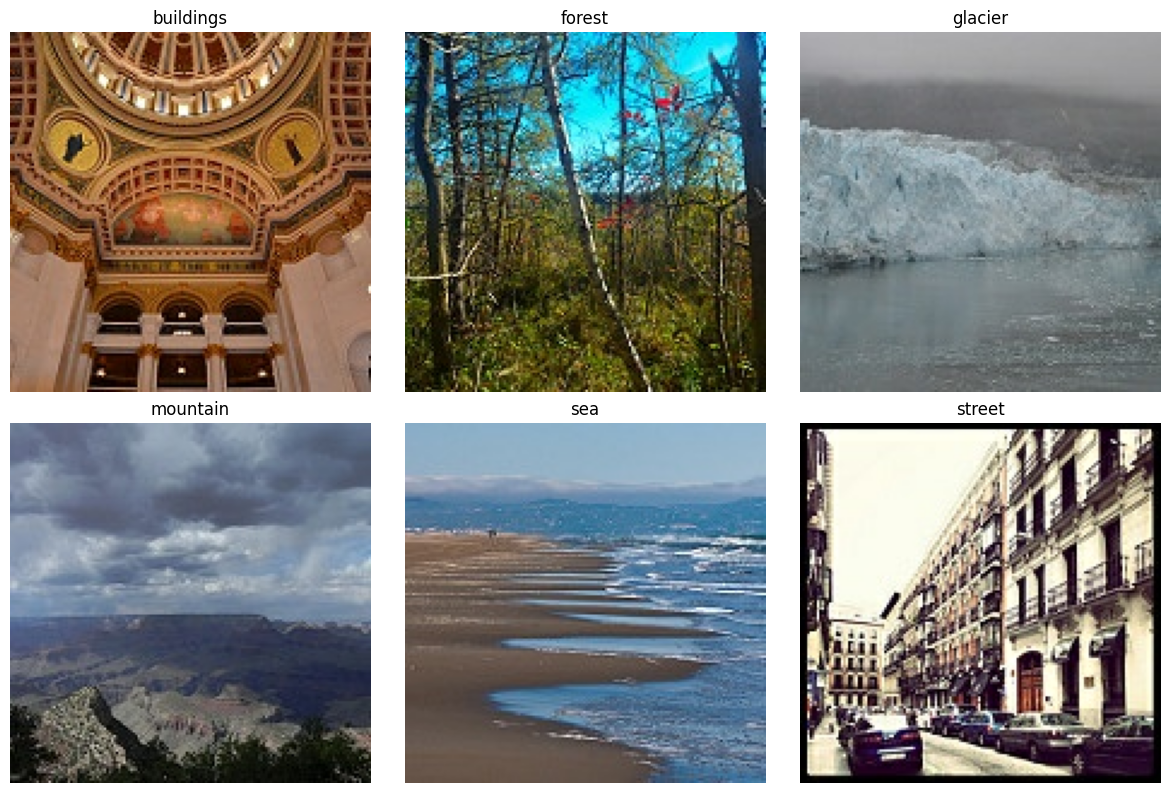

In [100]:
mostrar_ejemplos_por_clase(test_ds, class_names)

In [101]:
# Vemos valores de píxeles
for images, _ in train_ds.take(1):
    print("Mínimo valor de pixel:", images.numpy().min())
    print("Máximo valor de pixel:", images.numpy().max())

Mínimo valor de pixel: 0.0
Máximo valor de pixel: 255.0


Conclusión del Análisis y Preprocesamiento de los datos (EDA):

Este análisis nos indica que las imágenes son todas de un mismo tamaño y tienen un rango de valores adecuado. Además, las distribuciones por clase se encuentran relativamente balanceadas tanto en train como en test.
Los ejemplos de imágenes que visualizamos etiquetados con sus respectivas clases son coherentes con cada categoría.

## Definición y entrenamiento de modelos

Descomentar en caso de que se quiera reducir el tamaño del dataset para simular un escenario real donde no tenemos muchos datos o ejecutar en menos tiempo.


In [65]:
#train_ds = train_ds.take(7500)
#test_ds = test_ds.take(1500)

### Modelo con capas densas

In [102]:
# Modelo simple de capas densas
def crear_modelo_denso(input_shape, num_classes):
    modelo = Sequential([
        Input(shape=input_shape),
        Rescaling(1./255),                      # Normalización
        Flatten(),                              # Aplanado
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')  # Salida multicategoría
    ])
    return modelo

# Creamos el modelo
modelo_denso = crear_modelo_denso((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

# Compilamos el modelo
modelo_denso.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [103]:
# Callbacks para evitar overfitting
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

In [104]:
# División en entrenamiento y validación

""" optimiza la carga de datos para que TensorFlow no se quede esperando mientras entrena. Es decir,
mejora la performance del entrenamiento al ir cargando los datos en paralelo al entrenamiento mismo.
No cambia los datos ni vuelve a dividirlos: solo agrega eficiencia."""

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [105]:
# Entrenamiento
historial_denso = modelo_denso.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.2819 - loss: 6.0873 - val_accuracy: 0.3917 - val_loss: 1.5204 - learning_rate: 0.0010
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.3783 - loss: 1.5119 - val_accuracy: 0.4573 - val_loss: 1.3905 - learning_rate: 0.0010
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.3510 - loss: 1.5356 - val_accuracy: 0.3110 - val_loss: 1.5321 - learning_rate: 0.0010
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.3245 - loss: 1.5593 - val_accuracy: 0.3777 - val_loss: 1.4786 - learning_rate: 0.0010
Epoch 5/20
437/439 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3376 - loss: 1.5288
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.3376 - loss: 1.5287 - val_accuracy: 0.3833 - val_loss: 1.4443 - learning_rate: 0.0010
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3659 - loss

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5058 - loss: 1.2631
Pérdida en test: 1.2873
Precisión en test: 0.4980


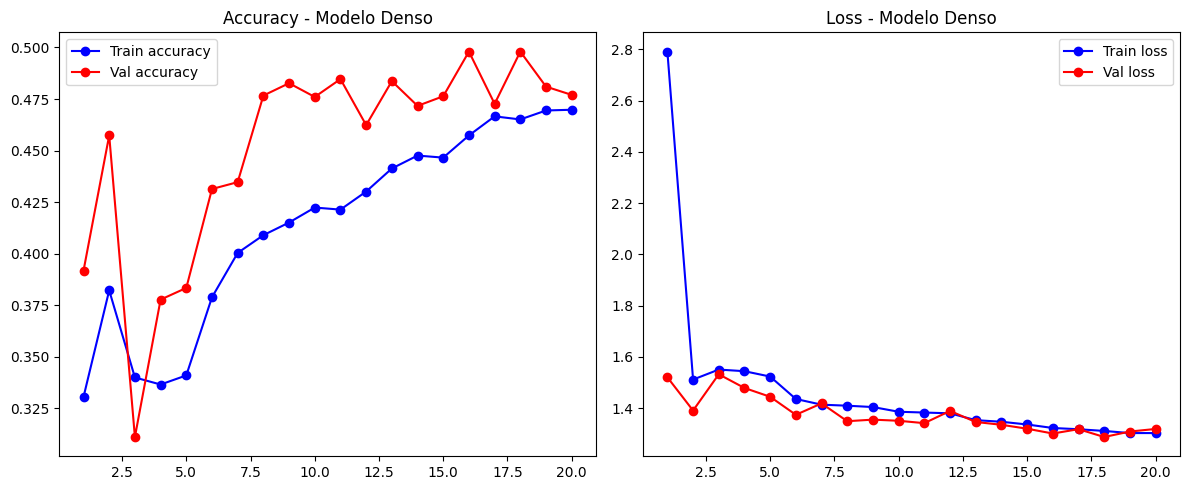

In [106]:
# Evaluamos el modelo con el set de test
loss, accuracy = modelo_denso.evaluate(test_ds)
print(f"Pérdida en test: {loss:.4f}")
print(f"Precisión en test: {accuracy:.4f}")

# Graficamos evolución del entrenamiento
def plot_training(historia, nombre_modelo):
    acc = historia.history['accuracy']
    val_acc = historia.history['val_accuracy']
    loss = historia.history['loss']
    val_loss = historia.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Train accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Val accuracy')
    plt.title(f'Accuracy - {nombre_modelo}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Train loss')
    plt.plot(epochs, val_loss, 'ro-', label='Val loss')
    plt.title(f'Loss - {nombre_modelo}')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(historial_denso, "Modelo Denso")

In [107]:
# Creamos un data para comparar los rendimientos de los modelos
comparacion = pd.DataFrame({
    'Modelo': ['Modelo Denso'],
    'Precisión en test': [accuracy],
    'Pérdida en test': [loss]
})

In [108]:
comparacion

Modelo  Precisión en test  Pérdida en test
0  Modelo Denso              0.498         1.287261

Conclusión:

El modelo de capas densas trata a cada imagen como una secuencia plana de píxeles sin considerar su estructura espacial.

Los resultados obtenidos fueron muy bajos, lo cual nos indica que el modelo no logra extraer patrones relevantes del contenido visual de las imágenes y refuerza lo que sabíamos de que las redes densas no son adecuadas para este tipo de tareas.


### Modelo con capas convolucionales y densas

In [109]:
# Definimos el modelo

def crear_modelo_conv_denso(input_shape, output_labels):
  i = Input(input_shape, dtype=tf.float32)

  # Estas capas aumentan la variedad del conjunto de datos "en vivo" durante el entrenamiento
  x = Rescaling(1./255)(i) # Normaliza la imagen a [0, 1]
  x = RandomFlip("horizontal")(x) # Giro horizontal
  x = RandomFlip("vertical")(x) # Giro vertical
  x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x) # Traslación
  x = RandomContrast(0.2)(x)  # Cambio de contraste

  x = Conv2D(8, (3, 3))(x) # filtros conv con kernel 3x3
  x = Activation("relu")(x)

  x = Conv2D(16, (3, 3))(x)
  x = Activation("relu")(x) # activa las salidas de cada convolución

  x = MaxPooling2D((2, 2))(x) # reduce la resolución espacial, conservando las características más importantes

  x = Conv2D(32, (3, 3))(x)
  x = Activation("relu")(x)

  x = MaxPooling2D((2, 2))(x)

  x = Conv2D(64, (3, 3))(x)
  x = Activation("relu")(x)

  x = MaxPooling2D((2, 2))(x)

  x = Flatten()(x)
  x = Dropout(0.3)(x)
  x = Dense(output_labels)(x)
  x = Activation("softmax")(x)
  return tf.keras.Model(inputs=[i], outputs=[x])


print("Building model")
modelo_conv_denso = crear_modelo_conv_denso((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

modelo_conv_denso.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])


Building model


In [110]:
modelo_conv_denso.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 150, 150, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 148, 148, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 148, 148, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 146, 146, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 146, 146, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 73, 73, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 71, 71, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 71, 71, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 33, 33, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 33, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 6)              │        98,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,838 (479.84 KB)

 Trainable params: 122,838 (479.84 KB)

 Non-trainable params: 0 (0.00 B)

In [111]:
# Entrenamos el modelo

history = modelo_conv_denso.fit(
    train_ds,
    validation_data=test_ds,
    epochs=30,
    batch_size=BATCH_SIZE
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_91']
Received: inputs=Tensor(shape=(None, 150, 150, 3))
  warnings.warn(msg)


439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.4587 - loss: 1.2987 - val_accuracy: 0.6717 - val_loss: 0.8745
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6670 - loss: 0.8660 - val_accuracy: 0.7397 - val_loss: 0.7200
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7188 - loss: 0.7496 - val_accuracy: 0.7540 - val_loss: 0.7018
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.7451 - loss: 0.6816 - val_accuracy: 0.7710 - val_loss: 0.6208
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7649 - loss: 0.6368 - val_accuracy: 0.7850 - val_loss: 0.6055
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7746 - loss: 0.6099 - val_accuracy: 0.7900 - val_loss: 0.6009
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7853 - loss: 0.5917 - val_accuracy: 0.8093 - val_loss: 0.5474
Epoch 8/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7990 - loss: 0.5535 - val_accurac

In [112]:
# Evaluamos el modelo en test

loss, accuracy = modelo_conv_denso.evaluate(test_ds)
print(f"Pérdida en test: {loss:.4f}")
print(f"Precisión en test: {accuracy:.4f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8220 - loss: 0.5007
Pérdida en test: 0.4606
Precisión en test: 0.8333


In [113]:
# agregamos nuevos datos al dataframe existente

metricas_modelo_denso = {
    'Modelo': 'Modelo Convolucional y Denso',
    'Precisión en test': accuracy,
    'Pérdida en test': loss
}

comparacion.loc[len(comparacion)] = metricas_modelo_denso
comparacion

Modelo  Precisión en test  Pérdida en test
0                  Modelo Denso           0.498000         1.287261
1  Modelo Convolucional y Denso           0.833333         0.460585

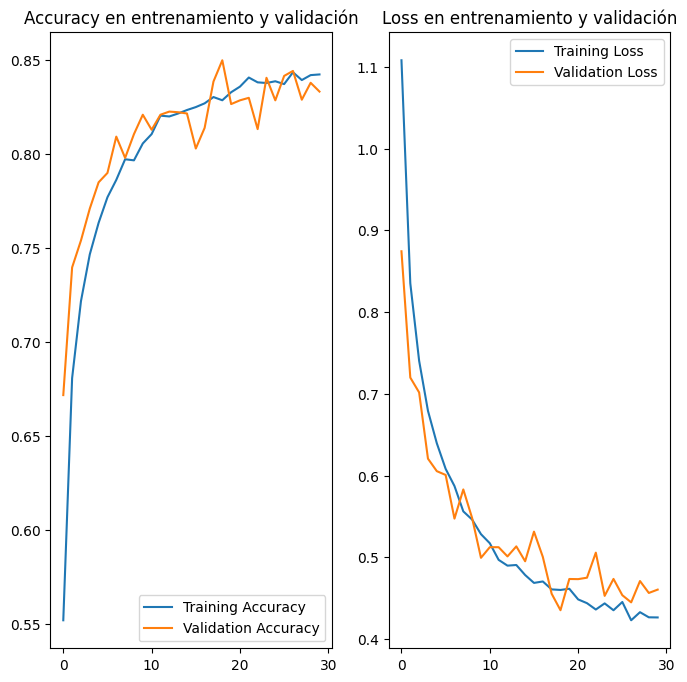

In [114]:
# Curvas de entrenamiento

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy en entrenamiento y validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss en entrenamiento y validación')
plt.show()

Conclusión:

Este modelo mejoró notablemente el desempeño respecto al modelo de únicamente capas densas, gracias al uso de capas convolucionales que extraen características espaciales relevantes. Además, las técnicas de aumento de datos (data augmentation) ayudaron a combatir el sobreajuste.

### Modelo que incluya bloques residuales identidad

In [115]:
# Definimos bloque residual

def resnet_block(x, filters, downsample=False):
    shortcut = x
    strides = (2, 2) if downsample else (1, 1)

    x = Conv2D(filters, (3, 3), strides=strides, padding='same', kernel_initializer='he_normal')(x)
    x = ReLU()(x)
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)

    if downsample:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same', kernel_initializer='he_normal')(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [116]:
# Definimos un modelo que usa los bloques residuales

def build_resnet_like_model(input_shape=(150, 150, 3), num_classes=6):
    inputs = Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal')(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, downsample=True)
    x = resnet_block(x, 128)

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

In [117]:
# Compilamos
model_resnet_like = build_resnet_like_model(input_shape=(150, 150, 3), num_classes=num_classes)
model_resnet_like.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [118]:
# Entrenamos el modelo
history_resnet_like = model_resnet_like.fit(train_ds, validation_data=test_ds, epochs=20, callbacks=callbacks)

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.3869 - loss: 1.5687 - val_accuracy: 0.5767 - val_loss: 1.0942 - learning_rate: 1.0000e-04
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - accuracy: 0.6175 - loss: 0.9902 - val_accuracy: 0.6750 - val_loss: 0.8541 - learning_rate: 1.0000e-04
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.6953 - loss: 0.8215 - val_accuracy: 0.7387 - val_loss: 0.7245 - learning_rate: 1.0000e-04
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7462 - loss: 0.7159 - val_accuracy: 0.7673 - val_loss: 0.6394 - learning_rate: 1.0000e-04
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.7592 - loss: 0.6747 - val_accuracy: 0.7790 - val_loss: 0.6013 - learning_rate: 1.0000e-04
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.7867 - loss: 0.6062 - val_accuracy: 0.8043 - val_loss: 0.5467 - learning_rate: 1.0000e-04
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/ste

In [119]:
# Evaluamos el modelo
test_loss, test_acc = model_resnet_like.evaluate(test_ds)
print(f"Accuracy en test: {test_acc:.4f}")
print(f"Pérdida en test: {test_loss:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8745 - loss: 0.3860
Accuracy en test: 0.8790
Pérdida en test: 0.3641


In [120]:
# agregamos nuevos datos al dataframe existente

metricas_bloques_residuales = {
    'Modelo': 'Modelo Bloques Residuales',
    'Precisión en test': test_acc,
    'Pérdida en test': test_loss
}

comparacion.loc[len(comparacion)] = metricas_bloques_residuales
comparacion

Modelo  Precisión en test  Pérdida en test
0                  Modelo Denso           0.498000         1.287261
1  Modelo Convolucional y Denso           0.833333         0.460585
2     Modelo Bloques Residuales           0.879000         0.364067

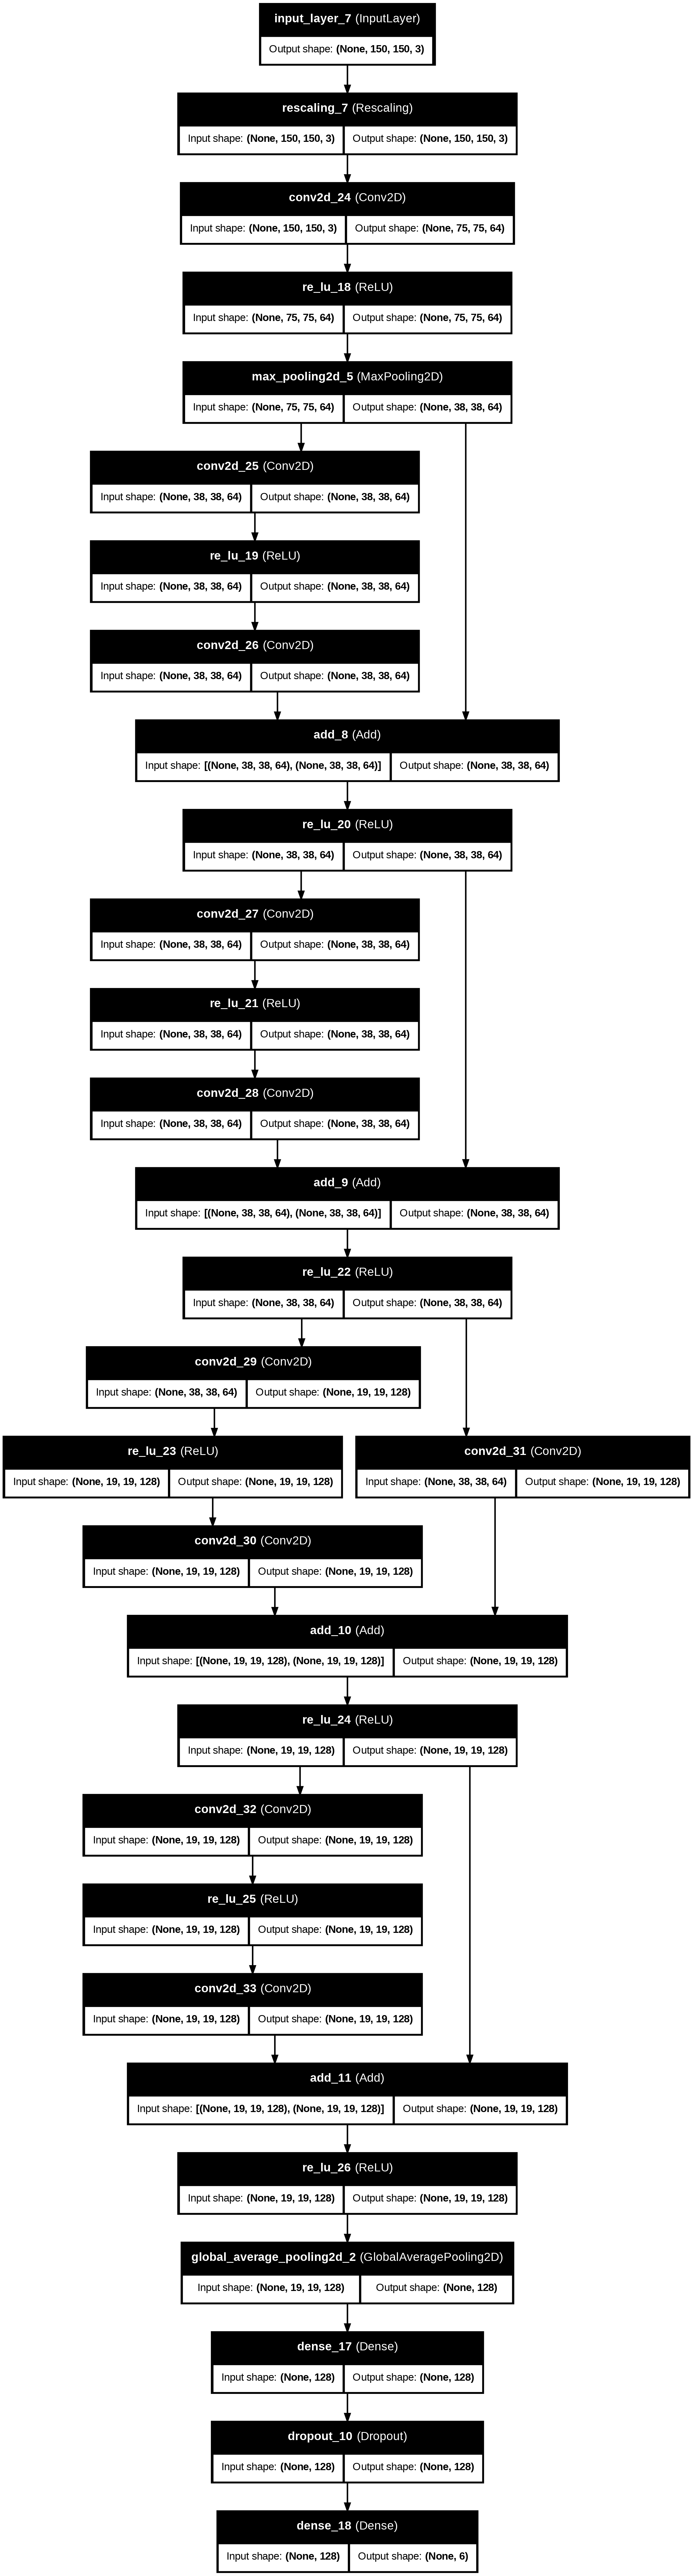

In [121]:
# Creamos imagen temporal del modelo
with tempfile.NamedTemporaryFile(suffix=".png") as tmpfile:
    plot_model(model_resnet_like, to_file=tmpfile.name, show_shapes=True, show_layer_names=True)
    display(Image(filename=tmpfile.name))

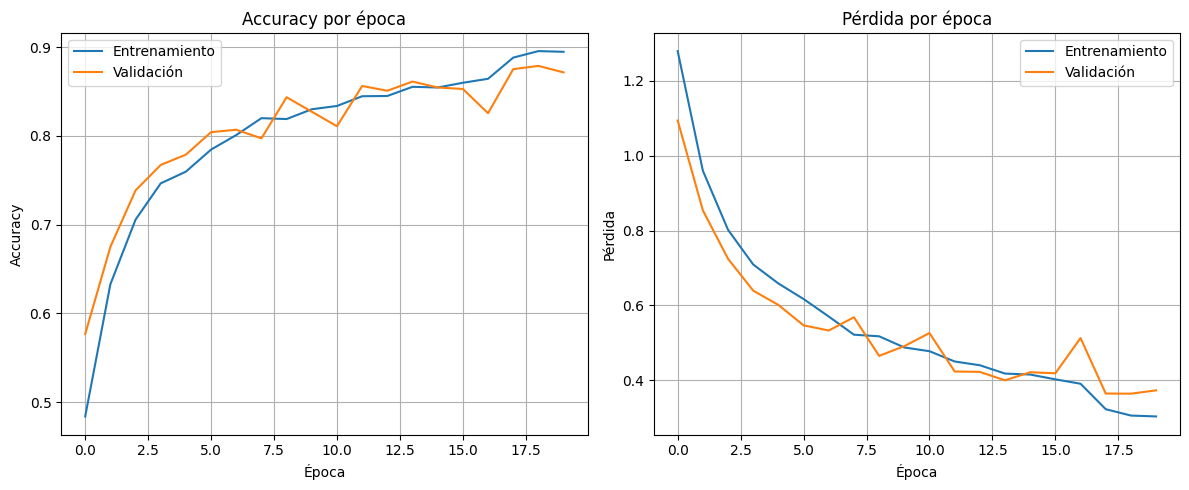

In [122]:
# Curvas de entrenamiento

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_like.history['accuracy'], label='Entrenamiento')
plt.plot(history_resnet_like.history['val_accuracy'], label='Validación')
plt.title('Accuracy por época')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history_resnet_like.history['loss'], label='Entrenamiento')
plt.plot(history_resnet_like.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Conclusión:

El modelo basado en bloques residuales introdujo mayor profundidad manteniendo la estabilidad del entrenamiento mediante conexiones de atajo. Esta arquitectura permitió alcanzar un rendimiento aún mejor.

### Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow (transfer learning)

EfficientNetB0



In [123]:
# Establecemos GPU por defecto si está disponible

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)


Physical devices cannot be modified after being initialized


In [124]:
# Definimos la arquitectura de la red

def build_tensorflow_model(input_shape, num_classes):
  base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet') # qué pesos pre-entrenados quiero usar
  base_model.trainable = False

  i = Input(shape=input_shape)
  x = base_model(i, training=False)
  x = GlobalMaxPooling2D()(x)

  x = Dropout(0.5)(x)

  x = Dense(num_classes, activation='softmax')(x)   # a ver si así no overfitea

  return tf.keras.Model(i, x)


In [125]:
# Construimos el modelo

print("Building model")
model_tensorflow = build_tensorflow_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model_tensorflow.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [126]:
model_tensorflow.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

En el summary podemos observar que del total params 4,057,257 sólo se van a entrenar 7,686 (por la compilación)

In [127]:
# Entrenamos el modelo
history = model_tensorflow.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    batch_size=BATCH_SIZE
)

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 63s 94ms/step - accuracy: 0.6632 - loss: 1.4441 - val_accuracy: 0.8820 - val_loss: 0.3809
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.8463 - loss: 0.5724 - val_accuracy: 0.8817 - val_loss: 0.3534
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.8617 - loss: 0.4847 - val_accuracy: 0.8983 - val_loss: 0.3543
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.8736 - loss: 0.4393 - val_accuracy: 0.8883 - val_loss: 0.4001
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.8712 - loss: 0.4417 - val_accuracy: 0.9013 - val_loss: 0.3272
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.8667 - loss: 0.4527 - val_accuracy: 0.8983 - val_loss: 0.3144
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.8712 - loss: 0.4451 - val_accuracy: 0.9010 - val_loss: 0.3173
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.8704 - loss: 0.4348 - 

In [128]:
# Evaluamos el modelo con el set de test
loss, accuracy = model_tensorflow.evaluate(test_ds)
print(f"Pérdida en test: {loss:.4f}")
print(f"Precisión en test: {accuracy:.4f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8888 - loss: 0.4075
Pérdida en test: 0.3400
Precisión en test: 0.9020


In [129]:
# agregamos nuevos datos al dataframe existente

metricas_tensorflow = {
    'Modelo': 'Modelo Tensorflow',
    'Precisión en test': accuracy,
    'Pérdida en test': loss
}

comparacion.loc[len(comparacion)] = metricas_tensorflow
comparacion

Modelo  Precisión en test  Pérdida en test
0                  Modelo Denso           0.498000         1.287261
1  Modelo Convolucional y Denso           0.833333         0.460585
2     Modelo Bloques Residuales           0.879000         0.364067
3             Modelo Tensorflow           0.902000         0.340039

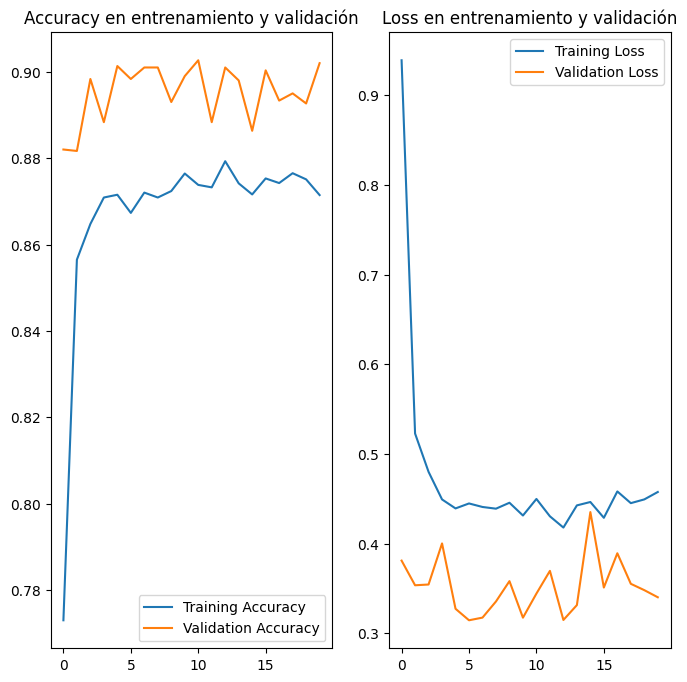

In [130]:
# Graficamos la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy en entrenamiento y validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss en entrenamiento y validación')
plt.show()

Conclusión:

Además de EfficientNetB0, exploramos otras arquitecturas preentrenadas disponibles en TensorFlow obteniendo los siguientes resultados:

MobileNet:
*   Pérdida en test: 0.6696
*   Precisión en test: 0.7557

ResNet50:
*   Pérdida en test: 0.9214
*   Precisión en test: 0.8913

EfficientNetB0 fue el que más se destacó entre ellos y entre los que ya habíamos entrenado. Obtuvo uno de los mejores rendimientos a pesar de entrenar muy pocos parámetros. Esto nos demuestra la eficiencia del transfer learning, ya que la red aprovechó representaciones ya aprendidas en grandes datasets, adaptándose  al problema actual con un bajo costo computacional. Además, la importancia de seleccionar la arquitectura que mejor se adapte a las características del problema y el dataset que tengamos.

## **Conclusión Final y Comparación de modelos**



In [131]:
comparacion

Modelo  Precisión en test  Pérdida en test
0                  Modelo Denso           0.498000         1.287261
1  Modelo Convolucional y Denso           0.833333         0.460585
2     Modelo Bloques Residuales           0.879000         0.364067
3             Modelo Tensorflow           0.902000         0.340039

A lo largo del trabajo práctico, vimos distintas arquitecturas de Redes Neuronales para clasificar imágenes de escenas naturales.

Comenzamos con un modelo denso simple y progresivamente incorporamos técnicas más sofisticadas como convoluciones, bloques residuales y TransferLearning.

En términos generales:

*   El modelo denso fue el menos efectivo, limitado por su incapacidad para aprovechar la estructura espacial de las imágenes.

*   El modelo convolucional denso demostró una mejora gracias al uso de filtros espaciales y data augmentation.

*   El modelo con bloques residuales mostró cómo arquitecturas más profundas pueden ser estables y eficientes si se diseñan adecuadamente.

*   El modelo con transferencia de aprendizaje (EfficientNetB0) fue el más eficiente y preciso, destacándose como la opción más robusta y práctica.

En conclusión: pudimos probar distintos tipos de redes neuronales y ver cómo cada mejora impacta en la clasificación de imágenes. Comprobamos que los modelos simples no son tan efectivos, mientras que las redes convolucionales, los bloques residuales y los modelos preentrenados como EfficientNetB0, dan resultados mucho mejores.